# Predicting Draft Picks
## 5. Modeling and Evaluation

I have previously collected, cleaned and tested my data around the NFL Draft. I added several new features in my previuos feature engineering notebook and now is time for the main event - modeling! And of course, model evaluation. I will iterate through different classifiers to determine which will best classify 'Drafted' vs 'Not Drafted' among my 5.5k observagtions.

No surprise, I must first load in my libraries and data.

In [356]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

In [357]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# setting format for readability
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [358]:
df = pd.read_pickle('../mod5project/pickle_files/final_data')
print(df.shape)
df.head()

(5492, 109)


,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,DraftedvNotDrafted,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,Feet,Inches,Pos,DoesntLieonDatingApps,SmallestKidontheBlock,SendEmBackwards,CatchTheQB,Scores_Kicking_Pts
0,Shaun Alexander,RB,Alabama,2000,72,218,4.580,17.230,9.699,59.135,3.533,2.133,Seattle Seahawks,1st,19th pick,2000,Drafted,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.091,0.000,0.000,0.000,11.000,302.000,1383.000,4.600,19.000,25.000,323.000,12.900,4.000,327.000,1706.000,5.200,23.000,27.455,125.727,1.727,2.273,29.364,0.364,29.727,155.091,2.091,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,0.000,24.000,0.000,0.000,144.000,72,0,Receivers,False,True,False,False,False
1,LaVar Arrington,OLB,Penn State,2000,75,250,4.530,17.246,11.273,58.797,3.567,2.143,Washington Redskins,1st,2nd pick,2000,Drafted,12.000,0.000,0.000,0.000,0.000,0.000,1.000,27.000,27.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.000,0.000,0.000,0.000,0.000,0.000,72,3,LBs,True,False,False,False,False
2,John Baker,P,North Texas,2000,75,227,2.459,15.667,8.091,56.950,3.578,2.210,Not Drafted,Not Drafted,Not Drafted,Not Drafted,Not Drafted,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,1.000,1.000,100.000,27.000,27.000,27.000,0.000,0.000,326.800,0.091,0.091,2.455,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,72,3,SpecialTeams,True,True,False,False,False
3,Anthony Becht,TE,West Virginia,2000,78,270,4.780,33.500,10.107,123.000,6.940,4.080,New York Jets,1st,27th pick,2000,Drafted,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.

I have some categorical columns that I'll need to create dummies for before running my models. Below I turn each of the following columns into dummies:

        * School
        * Position
        * Pos

After one-hot encoding each column, I add them to my dataframe. When I set my features, I'll drop the original column.

In [359]:
dummies = pd.get_dummies(df['School'], drop_first=True)
df = pd.concat([df, dummies], axis = 1)
dummies = pd.get_dummies(df['Position'], drop_first=True)
df = pd.concat([df, dummies], axis =1)
dummies = pd.get_dummies(df['Pos'], drop_first=True)
df = pd.concat([df, dummies], axis =1)
print(df.shape)
df.head()

(5492, 277)


,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,DraftedvNotDrafted,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,Feet,Inches,Pos,DoesntLieonDatingApps,SmallestKidontheBlock,SendEmBackwards,CatchTheQB,Scores_Kicking_Pts,Akron,Ala-Birmingham,Alabama,Appalachian State,Arizona,Arizona State,Arkansas,Arkansas State,Army,Auburn,BYU,Ball State,Baylor,Boise State,Boston Col.,Boston College,Bowling Green,Buffalo,California,Central Florida,Central Michigan,Charlotte,Cincinnati,Clemson,Colorado,Colorado State,Connecticut,Duke,East Carolina,East. Kentucky,East. Michigan,Florida,Florida Atlantic,Florida International,Florida State,Fresno State,Georgia,Georgia Southern,Georgia State,Georgia Tech,Hawaii,Houston,Idaho,Idaho State,Illinois,Indiana,Iowa,Iowa State,Kansas,Kansas State,Kent State,Kentucky,LSU,La-Monroe,Liberty,Louisiana,Louisiana Tech,Louisiana-Lafayette,Louisville,Marshall,Maryland,Massachusetts,Memphis,Miami,Miami (FL),Miami (OH),Michigan,Michigan State,Middle Tennessee State,Minnesota,Mississippi,Mississippi State,Missouri,Navy,Nebraska,Nevada,New Hampshire,New Mexico,New Mexico State,North Carolina,North Carolina State,North Texas,Northern Arizona,Northern Illinois,Northwestern,Northwestern St. (LA),Notre Dame,Ohio,Ohio State,Oklahoma,Oklahoma State,Old Dominion,Oregon,Oregon State,Penn State,Pittsburgh,Purdue,Rice,Rutgers,SMU,San Diego State,San Jose State,South Alabama,South Carolina,South Florida,Southern Miss,Stanford,Syracuse,TCU,Temple,Tennessee,Texas,Texas A&M,Texas State,Texas Tech,Texas-El Paso,Texas-San Antonio,Toledo,Troy,Tulane,Tulsa,UCF,UCLA,UNLV,USC,Utah,Utah State,Vanderbilt,Virginia,Virginia Tech,Wake Forest,Washington,Washington State,West Virginia,West. Michigan,Western Kentucky,Western Michigan,Wisconsin,Wyoming,CB,DB,DE,DL,DT,EDGE,FB,FS,ILB,K,LB,LS,NT,OG,OL,OLB,OT,P,QB,RB,S,SS,TE,WR,LBs,OffensiveLine,QBs,Receivers,SpecialTeams
0,Shaun Alexander,RB,Alabama,2000,72,218,4.580,17.230,9.699,59.135,3.533,2.133,Seattle Seahawks,1st,19th pick,2000,Drafted,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.091,0.000,0.000,0.000,11.000,302.000,1383.000,4.600,19.000,25.000,323.000,12.900,4.000,327.000,1706.000,5.200,23.000,27.455,125.727,1.727,2.273,29.364,0.364,29.727,155.091,2.091,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,0.000,24.000,0.000,0.000,144.000,72,0,Receivers,False,True,False,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

When I run my model through my ensemble methods, I don't need dummies but I do want to create category codes for those columns. I do so below and will save off a second 'features list'.

In [360]:
df['Position'] = df['Position'].astype('category').cat.codes
df['School'] = df['School'].astype('category').cat.codes
df['Pos'] = df['Pos'].astype('category').cat.codes
df.head()

,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,DraftedvNotDrafted,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,Feet,Inches,Pos,DoesntLieonDatingApps,SmallestKidontheBlock,SendEmBackwards,CatchTheQB,Scores_Kicking_Pts,Akron,Ala-Birmingham,Alabama,Appalachian State,Arizona,Arizona State,Arkansas,Arkansas State,Army,Auburn,BYU,Ball State,Baylor,Boise State,Boston Col.,Boston College,Bowling Green,Buffalo,California,Central Florida,Central Michigan,Charlotte,Cincinnati,Clemson,Colorado,Colorado State,Connecticut,Duke,East Carolina,East. Kentucky,East. Michigan,Florida,Florida Atlantic,Florida International,Florida State,Fresno State,Georgia,Georgia Southern,Georgia State,Georgia Tech,Hawaii,Houston,Idaho,Idaho State,Illinois,Indiana,Iowa,Iowa State,Kansas,Kansas State,Kent State,Kentucky,LSU,La-Monroe,Liberty,Louisiana,Louisiana Tech,Louisiana-Lafayette,Louisville,Marshall,Maryland,Massachusetts,Memphis,Miami,Miami (FL),Miami (OH),Michigan,Michigan State,Middle Tennessee State,Minnesota,Mississippi,Mississippi State,Missouri,Navy,Nebraska,Nevada,New Hampshire,New Mexico,New Mexico State,North Carolina,North Carolina State,North Texas,Northern Arizona,Northern Illinois,Northwestern,Northwestern St. (LA),Notre Dame,Ohio,Ohio State,Oklahoma,Oklahoma State,Old Dominion,Oregon,Oregon State,Penn State,Pittsburgh,Purdue,Rice,Rutgers,SMU,San Diego State,San Jose State,South Alabama,South Carolina,South Florida,Southern Miss,Stanford,Syracuse,TCU,Temple,Tennessee,Texas,Texas A&M,Texas State,Texas Tech,Texas-El Paso,Texas-San Antonio,Toledo,Troy,Tulane,Tulsa,UCF,UCLA,UNLV,USC,Utah,Utah State,Vanderbilt,Virginia,Virginia Tech,Wake Forest,Washington,Washington State,West Virginia,West. Michigan,Western Kentucky,Western Michigan,Wisconsin,Wyoming,CB,DB,DE,DL,DT,EDGE,FB,FS,ILB,K,LB,LS,NT,OG,OL,OLB,OT,P,QB,RB,S,SS,TE,WR,LBs,OffensiveLine,QBs,Receivers,SpecialTeams
0,Shaun Alexander,20,3,2000,72,218,4.580,17.230,9.699,59.135,3.533,2.133,Seattle Seahawks,1st,19th pick,2000,Drafted,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.091,0.000,0.000,0.000,11.000,302.000,1383.000,4.600,19.000,25.000,323.000,12.900,4.000,327.000,1706.000,5.200,23.000,27.455,125.727,1.727,2.273,29.364,0.364,29.727,155.091,2.091,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.000,0.000,24.000,0.000,0.000,144.000,72,0,4,False,True,False,False,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Setting Target & Features

Now that I have my dummy columns, I can set my target & feature lists. My target is simple - DraftedvNotDrafted. As for my features, I drop anything that my hypothesis tests failed to reject the null value for, meaning my means are not significantly different between Drafted and Not Drafted. I drop those columns along with the columns I don't need and that equal to my 'features'. I saved off my second features list to pass through my ensemble methods as 'features_rf'.

In [361]:
target = df['DraftedvNotDrafted']

In [362]:
features = df.drop(columns=['PlayerName', 'Position', 'School', 'CombineYear', 'Draft Team', 'Round', 
                            'Pick', 'Draft Year', 'DraftedvNotDrafted', 'Feet', 'Inches', 'Pos', '_40yd', 
                            'Completions', 'Pass_Attempts', 'Completion_Percent', 'Pass_Yards', 
                            'Pass_Yds_per_Attempt', 'Adj_Pass_Yds_per_Attempt', 'Pass_TDs', 
                            'Pass_Interceptions', 'Passer_Rating', 'CompletionsperGame', 
                            'Pass_AttemptsperGame', 'Pass_YardsperGame', 'Pass_TDsperGame', 
                            'Pass_InterceptionsperGame', 'Rush_Attempts', 'Rush_Yds',                                       
                            'Rush_Yds_per_Attempt', 'Rush_TDs', 'Receptions', 'Rec_Yds', 
                            'Rec_Yds_per_Reception', 'Rec_TDs', 'Plays_from_Scrimmage', 
                            'Scrimmage_Yds', 'Scrimmage_Yds_per_Attempt', 'Scrimmage_TDs',
                            'Rush_AttemptsperGame', 'Rush_YdsperGame', 'Rush_TDsperGame', 
                            'ReceptionsperGame', 'Rec_YdsperGame', 'Rec_TDsperGame', 
                            'Plays_from_ScrimmageperGame', 'Scrimmage_YdsperGame',
                            'Scrimmage_TDsperGame', 'Yds_per_KO_Return', 'KO_Returned_for_TD', 
                            'KO_Return_YdsperGame', 'KO_Returned_for_TDperGame', 'Scoring_Games', 
                            'TD_Other', 'TwoPT_Conversion', 'Safety', 'TTL_Points'])


In [363]:
features_rf = df.drop(columns=['PlayerName', 'CombineYear', 'Draft Team', 'Round', 
                               'Pick', 'Draft Year', 'DraftedvNotDrafted', 'Feet', 'Inches', '_40yd', 
                               'Completions', 'Pass_Attempts', 'Completion_Percent', 'Pass_Yards', 
                               'Pass_Yds_per_Attempt', 'Adj_Pass_Yds_per_Attempt', 'Pass_TDs', 
                               'Pass_Interceptions', 'Passer_Rating', 'CompletionsperGame', 
                               'Pass_AttemptsperGame', 'Pass_YardsperGame', 'Pass_TDsperGame', 
                               'Pass_InterceptionsperGame', 'Rush_Attempts', 'Rush_Yds',                                       
                               'Rush_Yds_per_Attempt', 'Rush_TDs', 'Receptions', 'Rec_Yds', 
                               'Rec_Yds_per_Reception', 'Rec_TDs', 'Plays_from_Scrimmage', 
                               'Scrimmage_Yds', 'Scrimmage_Yds_per_Attempt', 'Scrimmage_TDs',
                               'Rush_AttemptsperGame', 'Rush_YdsperGame', 'Rush_TDsperGame', 
                               'ReceptionsperGame', 'Rec_YdsperGame', 'Rec_TDsperGame', 
                               'Plays_from_ScrimmageperGame', 'Scrimmage_YdsperGame',
                               'Scrimmage_TDsperGame', 'Yds_per_KO_Return', 'KO_Returned_for_TD', 
                               'KO_Return_YdsperGame', 'KO_Returned_for_TDperGame', 'Scoring_Games', 
                               'TD_Other', 'TwoPT_Conversion', 'Safety', 'TTL_Points', 'Akron', 'Ala-Birmingham', 
                               'Alabama', 'Appalachian State', 'Arizona', 'Arizona State', 'Arkansas', 
                               'Arkansas State', 'Army', 'Auburn', 'BYU', 'Ball State', 'Baylor', 'Boise State', 
                               'Boston Col.', 'Boston College', 'Bowling Green', 'Buffalo', 'California', 
                               'Central Florida', 'Central Michigan', 'Charlotte', 'Cincinnati', 'Clemson', 
                               'Colorado', 'Colorado State', 'Connecticut', 'Duke', 'East Carolina', 
                               'East. Kentucky', 'East. Michigan', 'Florida', 'Florida Atlantic', 
                               'Florida International', 'Florida State', 'Fresno State', 'Georgia', 
                               'Georgia Southern', 'Georgia State', 'Georgia Tech', 'Hawaii', 'Houston',
                               'Idaho', 'Idaho State', 'Illinois', 'Indiana', 'Iowa', 'Iowa State', 'Kansas', 
                               'Kansas State', 'Kent State', 'Kentucky', 'LSU', 'La-Monroe', 'Liberty', 'Louisiana', 
                               'Louisiana Tech', 'Louisiana-Lafayette', 'Louisville', 'Marshall', 'Maryland', 
                               'Massachusetts', 'Memphis', 'Miami', 'Miami (FL)', 'Miami (OH)', 'Michigan',
                               'Michigan State', 'Middle Tennessee State', 'Minnesota', 'Mississippi', 
                               'Mississippi State', 'Missouri', 'Navy', 'Nebraska', 'Nevada', 'New Hampshire', 
                               'New Mexico', 'New Mexico State', 'North Carolina', 'North Carolina State', 
                               'North Texas', 'Northern Arizona', 'Northern Illinois', 'Northwestern', 
                               'Northwestern St. (LA)', 'Notre Dame', 'Ohio', 'Ohio State', 'Oklahoma', 
                               'Oklahoma State', 'Old Dominion', 'Oregon', 'Oregon State', 'Penn State', 
                               'Pittsburgh', 'Purdue', 'Rice', 'Rutgers', 'SMU', 'San Diego State', 
                               'San Jose State', 'South Alabama', 'South Carolina', 'South Florida', 
                               'Southern Miss', 'Stanford', 'Syracuse', 'TCU', 'Temple', 'Tennessee',
                               'Texas', 'Texas A&M', 'Texas State', 'Texas Tech', 'Texas-El Paso', 
                               'Texas-San Antonio', 'Toledo', 'Troy', 'Tulane', 'Tulsa', 'UCF', 'UCLA', 
                               'UNLV', 'USC', 'Utah', 'Utah State', 'Vanderbilt', 'Virginia', 'Virginia Tech', 
                               'Wake Forest', 'Washington', 'Washington State', 'West Virginia', 'West. Michigan',
                               'Western Kentucky', 'Western Michigan', 'Wisconsin', 'Wyoming', 'CB', 'DB', 'DE', 
                               'DL', 'DT', 'EDGE', 'FB', 'FS', 'ILB', 'K', 'LB', 'LS', 'NT', 'OG', 'OL', 'OLB', 'OT',
                               'P', 'QB', 'RB', 'S', 'SS', 'TE', 'WR', 'LBs', 'OffensiveLine', 'QBs', 'Receivers', 
                               'SpecialTeams'])


I'm going to be running a lot of models, so it'll be best to append the evaluation metrics to a dataframe to then pick which is the best. I'm going to append the model used, accuracy score, precision score, recall score, F1 score and ROC AUC score to understand how my model does. As I run each model, I will append that model's results to the dataframe to see all models in totality when complete.

In [442]:
global summary_df
summary_df = pd.DataFrame(columns=['Model','Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'])
summary_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score


## Functions

I want to try a bunch of different models and tune the hyperparameters to capture my targe variable. I built the following functions to make that easier. In order to track each model's success, I will be splitting my data into train and test sets. Each model will understandably be trained on my training data and I will use the test data to get the evaluation metrics to assess the goodness of fit.

In [365]:
def train_test(features, target):
    """
    This function splits the data to validate model perfomance.
    
    Parameters:
        features: feature list that will be used to fit the model.
        target: target variable.
        
    Returns:
        X_train, X_test, y_train, y_test
    
    """
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=17)
    return X_train, X_test, y_train, y_test

I'll be tuning the parameters I designated in each of the models, so I wanted to be able to call the actual variable name so I know just what I did in that instance. In order to do that, I found the code for this function from a post on [stack overflow](https://stackoverflow.com/questions/592746/how-can-you-print-a-variable-name-in-python).

In [366]:
def namestr(obj, namespace):
    """
    This function returns the name of a variable vs the content of the variable to be used when appending to the
    summary df.
    
    Parameters:
        obj: the object that you need the name for.
        namespace: namespace where variable has been defined.
        
    Returns:
        Name of a variable
    """
    return [name for name in namespace if namespace[name] is obj]

### Models

I want to use different kinds of models to try to fit this data, starting simply with a baseline model and then using more and more complicated models from there.

In [367]:
def baseline(features, target):
    """
    This function returns the baseline model for my classifier fitted to the training data.
    
    Parameters:
        features: feature list that will be used to fit the model.
        target: target variable.
        
    Returns:
        Fitted baseline model.
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    model = DummyClassifier(strategy='uniform', random_state=17)
    model = model.fit(X_train, y_train)
    return model

In [368]:
def logistic_regression(features, target):
    """
    This function returns a logistic regression model for my classifier fitted to the training data.
    
    Parameters:
        features: feature list that will be used to fit the model
        target: target variable
        
    Returns:
        Fitted logistic regression model.
    
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    model = LogisticRegression(random_state=17)
    model = model.fit(X_train, y_train)
    return model
    

In [369]:
def knn(features, target, n):
    '''
    This function runs k-nearest neighbor model fitted to the training data that has been scaled.
    
    Parameter: 
        features: feature list that will be used to fit the model
        target: target variable     
        n: number of neighbors
    
    Returns: 
       Fitted KNN model.
        
    '''
    
    X_train, X_test, y_train, y_test = train_test(features, target)
      
    model = KNeighborsClassifier(n_neighbors=n)
    model = model.fit(X_train, y_train)
    return model

In [370]:
def decision_tree(features, target, max_depth):
    """
    This function runs a decision tree classifier and fits it to the training data.
    
    Parameters:
        features: feature list that will be used to fit the model
        target: target variable     
        max_depth: depth the tree should go to
        
    Returns:
        Fitted Decision Tree model.
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    model = DecisionTreeClassifier(random_state=17, max_depth=max_depth)
    model = model.fit(X_train, y_train)
    return model

In [371]:
def random_forest(features, target, n_estimators=100, max_depth=None ,bootstrap=True, min_samples_split=2, max_features='auto'):
    """
    This function runs a random forest classifier and fits it to the training data.
    
    Parameters:
        features: feature list that will be used to fit the model
        target: target variable
        n_estimators: number of estimators in the forest, defaulted to 100
        max_depth: depth the tree should go to, defaulted to None
        bootstrap: should the data be bootstraped, defaulted to True
        min_samples_split: number of samples needed to split the to a new node, defaulted to 2
        max_features: amount of features each tree should include, defaulted to auto
               
    Returns:
        Fitted Random Forest model.
    
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    model = RandomForestClassifier(random_state=17, max_depth=max_depth, n_estimators=n_estimators, bootstrap=bootstrap, min_samples_split=min_samples_split)
    model = model.fit(X_train, y_train)
    return model

In [372]:
def adaboost(features, target, n_estimators=50, learning_rate=1.0):
    """
    This function runs an adaboost classifier and fits it to the training data.
    
    Parameters:
        features: feature list that will be used to fit the model
        target: target variable
        n_estimators: number of estimators at which boosting is terminated, defaulted to 50
        learning_rate: shrinks the contribution of each classifier, defaulted to 1.0
    
    Returns:
        Fitted AdaBoost model.
    
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    model = AdaBoostClassifier(random_state=17, n_estimators=n_estimators, learning_rate=learning_rate)
    model = model.fit(X_train, y_train)
    return model  

In [373]:
def gradient_boosting(features, target, n_estimators=100, learning_rate=0.1, min_samples_split=2, max_depth=3, max_features=None):
    """
    This function runs an gradient boosting classifier and fits it to the training data.
    
    Parameters:
        features: feature list that will be used to fit the model
        target: target variable
        n_estimators: number of estimators at which boosting is terminated, defaulted to 100
        learning_rate: shrinks the contribution of each classifier, defaulted to 0.1
        min_samples_split: number of samples required in order to split to a new node, defaulted to 2
        max_depth: how deep the trees can grow, defaulted to 3
        max_features: how many features to include for each tree, defaulted to None
    
    Returns:
        Fitted Gradient Boosting model.
    
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    model = GradientBoostingClassifier(random_state=17, n_estimators=n_estimators, learning_rate=learning_rate, min_samples_split=min_samples_split, max_depth=max_depth, max_features=max_features)
    model = model.fit(X_train, y_train)
    return model

In [374]:
def xgboost(features, target, max_depth=3, learning_rate=0.1):
    """
    This function runs a XGBoost classifier and fits it to the training data.
    
    Parameters:
        features: feature list that will be used to fit the model
        target: target variable
        learning_rate: shrinks the contribution of each classifier, defaulted to 0.1
        max_depth: how deep the trees can grow, defaulted to 3
    
    Returns:
        Fitted Gradient Boosting model.
    
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    model = XGBClassifier(random_state=17, learning_rate=learning_rate, max_depth=max_depth)
    model = model.fit(X_train, y_train)
    return model

### Class Imbalance

In [375]:
def random_undersampling(X_train, y_train):
    '''
    This function runs random undersampling to address class imbalance.
    
    Parameter: 
        X_train: independent variables after splitting
        y_train: dependent variable
        
    Returns: 
        This returns an updated dataset with random undersampling implemented.
    '''
    
    rus = RandomUnderSampler(random_state = 17)
    X_train, y_train = rus.fit_sample(X_train, y_train)
    return X_train, y_train

In [376]:
def random_oversampling(X_train, y_train):
    '''
    This function runs random oversampling to address class imbalance.
    
    Parameter: 
        X_train: independent variables after splitting
        y_train: dependent variable
        
    Returns: 
        This returns an updated dataset with random oversampling implemented.
    '''
    
    ros = RandomOverSampler(random_state = 17)
    X_train, y_train = ros.fit_sample(X_train, y_train)
    return X_train, y_train

In [377]:
def tomek_links(X_train, y_train):
    '''
    This function runs tomek link undersampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with tomek link undersampling implemented.
    '''
    tl = TomekLinks()
    X_train, y_train = tl.fit_sample(X_train, y_train)
    return X_train, y_train

In [378]:
def smote_tomek(X_train, y_train):
    '''
    This function runs a combination of SMOTE and tomek link to address class imbalance.
    
    Parameter: 
        X_train: independent variables after splitting
        y_train: dependent variable
        
    Returns: 
        This returns an updated dataset with SMOTE and tomek link implemented.
    '''
    
    smt = SMOTETomek(random_state = 17)
    X_train, y_train = smt.fit_sample(X_train, y_train)
    return X_train, y_train

In [379]:
def solve_imbalance(model_type, imbalance_solution, features, target):
    """
    This function solves for the class imbalance.
    
    Parameters:
        model_type: classifier model used.
        imbalance_solution: method of solving class imbalance
        features: independent variables
        target: dependent variable
        
    Returns:
        Fitted model with class imbalance addressed.
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    X_train, y_train = imbalance_solution(X_train, y_train)
    
    model = model_type
    model = model.fit(X_train, y_train)
    return model

### Cross Validation and Scoring

In [380]:
def grid_search_cv(model, features, target, params, n_jobs, cv):
    '''
    This function automatically runs grid search cross validation for hyperparameter tuning and determining the 
    set of parameters that would produce the best results.
    
    Parameters: 
        model: model to be used for fitting
        features: independent variables
        target: dependent variable       
        params: parameters after hypertuning
        n_jobs: number of parallel jobs to run
        cv: number of cross-validation folds
        
    Returns: 
        This returns the best parameters.
    '''
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    grid_search = GridSearchCV(estimator = model, param_grid = params, 
                          n_jobs=n_jobs, cv = cv)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

In [381]:
def scoring(model, features, target):
    """
    This model returns the pertinent evaluation matrix appended to the summary_df dataframe for evaluation.
    
    Parameters:
        model: model to be used for fitting
        features: independent variables
        target: dependent variable       
        
    Returns:
        summary_df with evaluation metrics.
    """
    
    model_name = namestr(model, globals())
    model_name = str(model_name).strip('[]')
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    test_predictions = model.predict(X_test)
    
    accuracy = metrics.accuracy_score(y_test, test_predictions)
    precision = metrics.precision_score(y_test, test_predictions, average='weighted')
    recall = metrics.recall_score(y_test, test_predictions, average='weighted')
    f1_score = metrics.f1_score(y_test, test_predictions, average='weighted')
    
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    
    y_pred = model.predict(X_test)
    y_pred = lb.transform(y_pred)
    
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred, average='weighted')
    
    global summary_df
    summary_df = summary_df.append({'Model': model_name,
                                    'Accuracy': accuracy, 
                                    'Precision': precision, 
                                    'Recall': recall, 
                                    'F1 Score': f1_score, 
                                    'ROC AUC Score': roc_auc}, 
                                   ignore_index=True)
    
    return summary_df

In [382]:
def plot_auc_curve(model, features, target):
    """
    This function plots the AUC Curve for a given model.
    
    Parameters:
        model: model to be used for fitting
        features: independent variables
        target: dependent variable       
    
    Returns:
        Plotted AUC Curve.
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    model_name = namestr(model, globals())
    model_name = str(model_name).strip('[]') 
    
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    
    y_pred = model.predict(X_test)
    y_pred = lb.transform(y_pred)
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(model_name + 'ROC_Curve')
    plt.show()    

In [383]:
def plot_conf_matrix(model, features, target):
    """
    This function plots the confusion matrix for a designated model.
    
    Parameters:
        model: model to be used for fitting
        features: independent variables
        target: dependent variable       
    
    Returns:
        Plotted confusion matrix.
    
    """
    
    X_train, X_test, y_train, y_test = train_test(features, target)
    
    model_name = namestr(model, globals())
    model_name = str(model_name).strip('[]') 
    
    predictions = model.predict(X_test)
   
    cm = confusion_matrix(y_test, predictions)
    
    cmap = plt.cm.Blues
    
    ticks = ['Drafted', 'Not Drafted']
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(ticks))
    plt.xticks(tick_marks, ticks, rotation=45)
    plt.yticks(tick_marks, ticks)
    plt.colorbar()

    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")
    
    plt.savefig(model_name + '_CM')
    plt.show()

In [440]:
def feature_importance(model, X, y):
    """
    This function returns the top 10 important features for the model called in the parameters.
    
    Parameters:
        model:
        X: independent variables
        y: dependent variable
        
    Returns:
        Printed list of features and their importance % and a plot for the top 10 features.
    
    """
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)
    std_top10 = std[:10]
    indices = np.argsort(importances)[:: -1]
    feature_list = indices[:10]
    
    top_10 = importances[indices][:10]
    # Print the feature ranking
    print("Feature ranking:")
    
    for f in range(10):
#         print(X.shape[1])
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
    x_ticks = []
    
    for i in feature_list:
        feat_name = list(features)[i]
        x_ticks.append(feat_name)
    
    plt.figure(figsize = (10, 6))
    plt.title("Feature Importance")
    plt.bar(range(10), top_10, color="b", yerr = std_top10, align='edge')
    plt.xticks(range(10), x_ticks, rotation = 45)
    plt.savefig('images/best_model_feat_import')
    plt.show()

## Modeling

#### Base Model

In [443]:
base_model = baseline(features, target)
scoring(base_model, features, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491


#### Logistic Regression

In [444]:
logistic = logistic_regression(features, target)
scoring(logistic, features, target)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547


#### K-Nearest Neighbors

In [445]:
knn_3 = knn(features, target, 3)
scoring(knn_3, features, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565


In [446]:
knn_5 = knn(features, target, 5)
scoring(knn_5, features, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565


#### Decision Trees

In [447]:
dec_tree_3 = decision_tree(features, target, 3)
scoring(dec_tree_3, features, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501


In [448]:
dec_tree_5 = decision_tree(features, target, 5)
scoring(dec_tree_5, features, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523


### Ensemble Methods

#### Random Forest

In [449]:
random_forest_default = random_forest(features_rf, target)
scoring(random_forest_default, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583


In [450]:
# Random Forest Parameters

n_estimators = [100, 200, 300, 400, 500]
max_depth = [2, 3, 4, 5, 10]
bootstrap = [True, False]
min_samples_split = [2, 5, 10]
max_features = ['auto', 'sqrt', 'log2']

params = {'n_estimators': n_estimators, 
          'max_depth': max_depth, 
          'bootstrap': bootstrap, 
          'min_samples_split': min_samples_split, 
          'max_features': max_features}

In [451]:
grid_search_cv(RandomForestClassifier(random_state=17), features_rf, target, params = params, n_jobs=-1, cv=3)

{'bootstrap': False,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 500}

In [452]:
random_forest_gs = random_forest(features_rf, target, bootstrap=False, max_depth=10, max_features='auto', 
                                 min_samples_split=2, n_estimators=500)
scoring(random_forest_gs, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557


#### AdaBoost

In [453]:
adaboost_default = adaboost(features_rf, target)
scoring(adaboost_default, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572


In [454]:
# AdaBoost Parameters

n_estimators = [50, 100, 200, 300, 400, 500]
learning_rate = [1.0, 0.5, 1.5, 2.0]

params = {'n_estimators': n_estimators, 
          'learning_rate': learning_rate}

In [455]:
grid_search_cv(AdaBoostClassifier(random_state=17), features_rf, target, params = params, n_jobs=-1, cv=3)

{'learning_rate': 0.5, 'n_estimators': 200}

In [456]:
adaboost_gs = adaboost(features_rf, target, n_estimators=200, learning_rate=0.5)
scoring(adaboost_gs, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


#### Gradient Boosting

In [457]:
gradient_boost_def = gradient_boosting(features_rf, target)
scoring(gradient_boost_def, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [458]:
# Gradient Boost Parameters

n_estimators = [100, 200, 300, 400, 500]
max_depth = [2, 3, 4, 5, 10]
min_samples_split = [2, 5, 10]
max_features = ['auto', 'sqrt', 'log2']
learning_rate = [0.1, 0.5, 1.0]

params = {'n_estimators': n_estimators, 
          'max_depth': max_depth,  
          'min_samples_split': min_samples_split, 
          'max_features': max_features, 
          'learning_rate': learning_rate}

In [459]:
grid_search_cv(GradientBoostingClassifier(random_state=17), features_rf, target, params = params, n_jobs=-1, cv=3)

{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 300}

In [460]:
gradient_boost_gs = gradient_boosting(features_rf, target, n_estimators=300, max_depth=3, min_samples_split=10,
                                      max_features='sqrt', learning_rate=0.1)
scoring(gradient_boost_gs, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


#### XGBoost

In [461]:
xgboost_default = xgboost(features_rf, target)
scoring(xgboost_default, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [462]:
# XGBoost Parameters

max_depth = [2, 3, 4, 5, 10]
learning_rate = [0.1, 0.5, 1.0]

params = {'max_depth': max_depth,  
          'learning_rate': learning_rate}

In [463]:
grid_search_cv(XGBClassifier(random_state=17), features_rf, target, params = params, n_jobs=-1, cv=3)

{'learning_rate': 0.1, 'max_depth': 3}

In [464]:
xgboost_gs = xgboost(features_rf, target, learning_rate=0.1, max_depth=3)
scoring(xgboost_gs, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


### Handling Class Imbalance

I've run all my models, but I'm only getting to a 72.1% accuracy rate. I want to address any class imbalance issues I might have. I'm going to use my imbalance function and pass each of my ensemble methods through. I used the parameters my grid search returns for each and different class imbalance solution methods. Let's see if this gets me anywhere with my accuracy.

#### Random Forest

In [465]:
random_forest_rus = solve_imbalance(RandomForestClassifier(random_state=17, bootstrap=False, max_depth=10, 
                                                          max_features='auto', min_samples_split=2, n_estimators=500), 
                                    random_undersampling, features_rf, target)
scoring(random_forest_rus, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [466]:
random_forest_ros = solve_imbalance(RandomForestClassifier(random_state=17, bootstrap=False, max_depth=10, 
                                                           max_features='auto', min_samples_split=2, 
                                                           n_estimators=500), random_oversampling, features_rf, target)
scoring(random_forest_ros, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [467]:
random_forest_st = solve_imbalance(RandomForestClassifier(random_state=17, bootstrap=False, max_depth=10, 
                                                          max_features='auto', min_samples_split=2, n_estimators=500),
                                   smote_tomek, features_rf, target)
scoring(random_forest_st, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [468]:
random_forest_tomek = solve_imbalance(RandomForestClassifier(random_state=17, bootstrap=False, max_depth=10, 
                                                             max_features='auto', min_samples_split=2, 
                                                             n_estimators=500), tomek_links, features_rf, target)
scoring(random_forest_tomek, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


#### AdaBoost

In [469]:
adaboost_rus = solve_imbalance(AdaBoostClassifier(random_state = 17, n_estimators=200, learning_rate=0.5), 
                               random_undersampling, features_rf, target)
scoring(adaboost_rus, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [470]:
adaboost_ros = solve_imbalance(AdaBoostClassifier(random_state = 17, n_estimators=200, learning_rate=0.5), 
                               random_oversampling, features_rf, target)
scoring(adaboost_ros, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [471]:
adaboost_st = solve_imbalance(AdaBoostClassifier(random_state = 17, n_estimators=200, learning_rate=0.5), 
                              smote_tomek, features_rf, target)
scoring(adaboost_st, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [472]:
adaboost_tomek = solve_imbalance(AdaBoostClassifier(random_state = 17, n_estimators=200, learning_rate=0.5), 
                                 tomek_links, features_rf, target)
scoring(adaboost_tomek, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


#### Gradient Boosting

In [473]:
gradboost_rus = solve_imbalance(GradientBoostingClassifier(random_state=17, n_estimators=300, max_depth=3,
                                                           min_samples_split=10, max_features='sqrt', 
                                                           learning_rate=0.1), random_undersampling, features_rf,
                                target)
scoring(gradboost_rus, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [474]:
gradboost_ros = solve_imbalance(GradientBoostingClassifier(random_state=17, n_estimators=300, max_depth=3,
                                                           min_samples_split=10, max_features='sqrt', 
                                                           learning_rate=0.1), random_oversampling, features_rf, 
                                target)
scoring(gradboost_ros, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [475]:
gradboost_tomek = solve_imbalance(GradientBoostingClassifier(random_state=17, n_estimators=300, max_depth=3,
                                                             min_samples_split=10, max_features='sqrt', 
                                                             learning_rate=0.1), tomek_links, features_rf, target)
scoring(gradboost_tomek, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [476]:
gradboost_st = solve_imbalance(GradientBoostingClassifier(random_state=17, n_estimators=300, max_depth=3,
                                                          min_samples_split=10, max_features='sqrt', 
                                                          learning_rate=0.1), smote_tomek, features_rf, target)
scoring(gradboost_st, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


#### XGBoost

In [477]:
xgboost_rus = solve_imbalance(XGBClassifier(random_state=17, learning_rate=0.1, max_depth=3), 
                              random_undersampling, features_rf, target)
scoring(xgboost_rus, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [478]:
xgboost_ros = solve_imbalance(XGBClassifier(random_state=17, learning_rate=0.1, max_depth=3), 
                              random_oversampling, features_rf, target)
scoring(xgboost_ros, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [479]:
xgboost_st = solve_imbalance(XGBClassifier(random_state=17, learning_rate=0.1, max_depth=3), 
                             smote_tomek, features_rf, target)
scoring(xgboost_st, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


In [480]:
xgboost_tomek = solve_imbalance(XGBClassifier(random_state=17, learning_rate=0.1, max_depth=3),
                                tomek_links, features_rf, target)
scoring(xgboost_tomek, features_rf, target)

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491
1,'logistic',0.693,0.648,0.693,0.640,0.547
2,'knn_3',0.654,0.637,0.654,0.643,0.565
3,'knn_5',0.668,0.641,0.668,0.649,0.565
4,'dec_tree_3',0.694,0.594,0.694,0.578,0.501
5,'dec_tree_5',0.698,0.649,0.698,0.611,0.523
6,'random_forest_default',0.708,0.677,0.708,0.673,0.583
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
8,'adaboost_default',0.690,0.656,0.690,0.660,0.572
9,'adaboost_gs',0.697,0.663,0.697,0.664,0.574


## Model Evaluation

I ran my data through 30 models including my base model. I made some good improvement to my base so now I need to pick my best model.

My priority will be looking at the accuracy score since that will tell me just how many predictions my model gets right in the form of the ratio of correct predictions over total predictions. But accuracy alone won't be enough. I also want to take into consideration my F1 Score, or the harmonic mean of precision and recall. I want a model with good precision and recall and my F1 Score will balance between those two.

First, I want to understand my base model.

In [481]:
summary_df[summary_df['Model'] == "'base_model'"]

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,'base_model',0.489,0.570,0.489,0.510,0.491


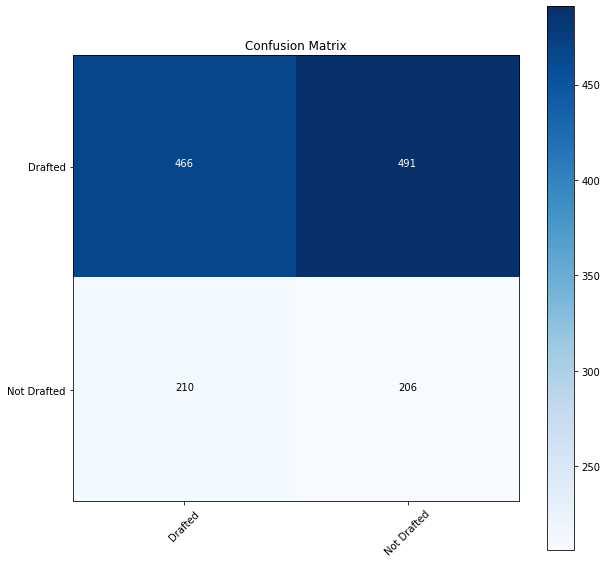

In [482]:
plot_conf_matrix(base_model, features, target)

My base model gets half my observations right, but it's often placing true 'Drafted' observations in the 'Not Drafted' bucket giving me low recall. This is just my jumping off point so there's plenty of room for improvement.

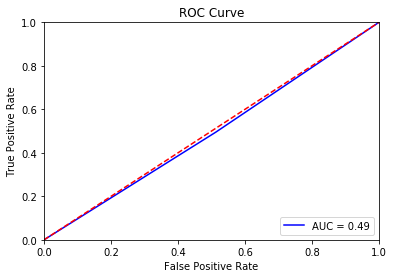

In [483]:
plot_auc_curve(base_model, features, target)

I've included my ROC Curve. The ROC Curve captures how well my model is able to distinguish between each of my classes. The base model is just that -- it's a jumping off point to then compare my other models to. My base model has an AUC of 0.49. It has no class separation between 'Drafted' and 'Not Drafted'.

#### Best Model

In [484]:
summary_df.sort_values('Accuracy', ascending=False)[:5]

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
10,'gradient_boost_def',0.721,0.696,0.721,0.676,0.583
11,'gradient_boost_gs',0.720,0.695,0.720,0.692,0.605
7,'random_forest_gs',0.717,0.699,0.717,0.650,0.557
17,'random_forest_tomek',0.714,0.686,0.714,0.678,0.587
13,'xgboost_gs',0.709,0.675,0.709,0.659,0.565


In [485]:
summary_df.sort_values('F1 Score', ascending=False)[:5]

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
11,'gradient_boost_gs',0.720,0.695,0.720,0.692,0.605
24,'gradboost_tomek',0.701,0.684,0.701,0.689,0.615
25,'gradboost_st',0.686,0.686,0.686,0.686,0.629
17,'random_forest_tomek',0.714,0.686,0.714,0.678,0.587
10,'gradient_boost_def',0.721,0.696,0.721,0.676,0.583


In [486]:
summary_df.sort_values('ROC AUC Score', ascending=False)[:5]

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
23,'gradboost_ros',0.661,0.700,0.661,0.673,0.650
22,'gradboost_rus',0.632,0.699,0.632,0.647,0.646
19,'adaboost_ros',0.645,0.693,0.645,0.658,0.642
27,'xgboost_ros',0.639,0.690,0.639,0.653,0.638
15,'random_forest_ros',0.662,0.685,0.662,0.671,0.633


Now when I look at my models and the 3 metrics I'm interested in, I get a different option as my best model. I want to take a weighted average of the three. A weighted average is just that - I assign weights for each metric, multiply that weight by the score in question and add the three together to get one super sum. I do want to weigh accuracy just a little bit more, so I give that a .4 weight and then weigh F1 and ROC AUC evenly.

In [491]:
accuracy_weight = .4
f1_weight = .3
roc_auc_weight = 1 - (accuracy_weight + f1_weight)

summary_df['Weighted Score'] = (summary_df['Accuracy'] * accuracy_weight) + (summary_df['F1 Score'] * f1_weight) + (summary_df['ROC AUC Score'] * roc_auc_weight)

In [492]:
summary_df.sort_values('Weighted Score', ascending=False)[:5]

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score,Weighted Score
11,'gradient_boost_gs',0.720,0.695,0.720,0.692,0.605,0.677
24,'gradboost_tomek',0.701,0.684,0.701,0.689,0.615,0.671
25,'gradboost_st',0.686,0.686,0.686,0.686,0.629,0.669
10,'gradient_boost_def',0.721,0.696,0.721,0.676,0.583,0.666
17,'random_forest_tomek',0.714,0.686,0.714,0.678,0.587,0.665


Let's step back - my best model in terms of accuracy is a gradient boosting set the the default parameters,  but when I look at my F1 Score and ROC AUC Score, this model isn't that strong. I sorted to see my top performing models based on F1 Score, gradient boosting tuned using grid search is my top performer. I really don't give up much in terms of accuracy, but see great improvements in my ROC AUC Score and gain a decent improvement in my F1 Score. I'm still not sold on it. When I sorted on ROC AUC Score, another gradient boosting model popped up, this time with random oversampling to address the imbalance problem. While it has the highest ROC AUC, I give up a lot of room in my accuracy score.

Enter my new weighted score - accuracy alone is not enough. So based on this weighted score, my best model is **gradient_boost_gs** .

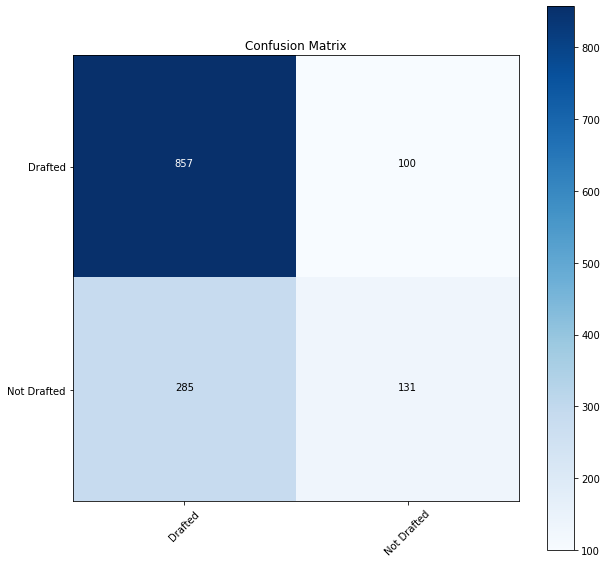

In [493]:
plot_conf_matrix(gradient_boost_gs, features_rf, target)

This model gets about 70% of observations labeled correctly, but it doesn't get everything right. My model tends to misclassify true 'Drafted' observations as 'Not Drafted' causing my Precision to drop since these are False Positives. When I look at the ROC Curve, I can see that my model has a 61% change of distinguishing between 'Drafted' and 'Not Drafted'. It's certainly better than my baseline model.

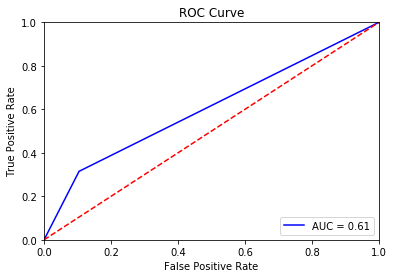

In [496]:
plot_auc_curve(gradient_boost_gs, features_rf, target)

In [497]:
len(list(features_rf))

55

Feature ranking:
1. feature 3 (0.088696)
2. feature 6 (0.081080)
3. feature 4 (0.074807)
4. feature 48 (0.072475)
5. feature 5 (0.071776)
6. feature 8 (0.056678)
7. feature 7 (0.053216)
8. feature 2 (0.052571)
9. feature 1 (0.039352)
10. feature 13 (0.038676)


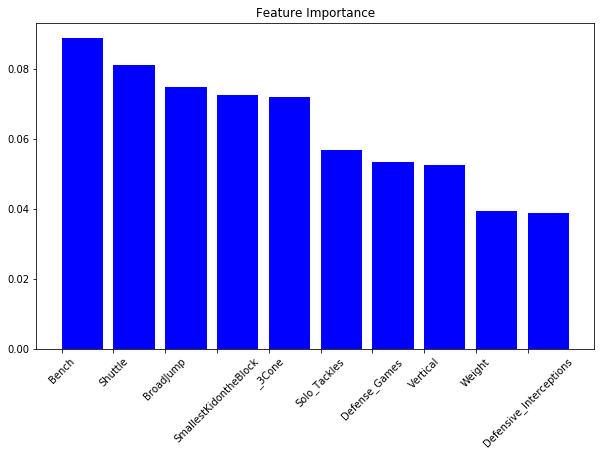

In [498]:
feature_importance(gradient_boost_gs, features_rf, target)

When it comes to features, with dummies, I have 217 features. Really, it's 55 features I'm using to predict Drafted vs Not Drafted. My top 10 features are dominated by combine results. All make an appearance in the top 10 features. One of the features I engineered also is included in the top 10 - 'SmallestKidontheBlock' where a player's weight is under 230lbs.